In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


In [75]:
# Function to parse data from a file
def parse_data(file_path):
    sequences = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            cleaned_line = line.strip()
            if cleaned_line in {"end", "<end>"}:
                sequences.append("end")
                labels.append("end")
            elif len(cleaned_line.split()) == 2:
                parts = cleaned_line.split()
                sequences.append(parts[0])  # Amino acid
                labels.append(parts[1])  # Secondary structure label
            else:
                continue  # Skip any malformed lines
    return sequences, labels

# Function to encode sequences
def encode_sequences(sequences):
    amino_acid_mapping = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, 'end': 20}
    encoded_seqs = np.zeros((len(sequences), 21))
    for idx, amino_acid in enumerate(sequences):
        encoded_seqs[idx, amino_acid_mapping[amino_acid]] = 1
    return encoded_seqs

# Function to encode labels
def encode_labels(labels):
    label_mapping = {'e': 0, 'h': 1, '_': 2, 'end': 3}
    encoded_labels = np.zeros((len(labels), 3))  # No need for encoding 'end'
    for idx, label in enumerate(labels):
        if label != 'end':
            encoded_labels[idx, label_mapping[label]] = 1
    return encoded_labels

# Load and process training and test data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")

eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)


In [76]:
def test_econding():
    #Confirm that the encoding is correct
    foundVal = ""
    count = 0
    while foundVal != "end":
        foundVal = seq[count]
        fV = eseq[count]
        #print("Character",foundVal,"is encoded as",fV)
        
        count += 1

    print("End found at:",count)
    count = 0
    foundVal = []
    while foundVal != [0]*20 + [1]: # when it finds foundVal = [0]*21, it will stop
        foundVal = eseq[count]
        count += 1   
print("End found at:",count)

End found at: 0


In [126]:
# Function to create sliding windows
def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows

# Prepare windowed input for model
windowed_input_train = create_sliding_windows(np.array(eseq_train))
windowed_input_test = create_sliding_windows(np.array(eseq_test))

# Build the model
def build_model(input_shape):
    #learning_rate = 0.0005
    #optim = Adam(learning_rate=learning_rate)
    optim = SGD()
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [127]:

model = build_model(windowed_input_train.shape[1])

# Train the model
history = model.fit(windowed_input_train, np.array(elab_train), epochs=100, validation_data=(windowed_input_test, np.array(elab_test)), batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(windowed_input_test, np.array(elab_test))
print("Test accuracy:", test_accuracy)


Epoch 1/100
569/569 [==============================] - 1s 2ms/step - loss: 0.9968 - accuracy: 0.5423 - val_loss: 0.9983 - val_accuracy: 0.5440
Epoch 2/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9906 - accuracy: 0.5423 - val_loss: 0.9943 - val_accuracy: 0.5440
Epoch 3/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9853 - accuracy: 0.5423 - val_loss: 0.9895 - val_accuracy: 0.5440
Epoch 4/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9797 - accuracy: 0.5423 - val_loss: 0.9841 - val_accuracy: 0.5440
Epoch 5/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9740 - accuracy: 0.5423 - val_loss: 0.9793 - val_accuracy: 0.5440
Epoch 6/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9681 - accuracy: 0.5424 - val_loss: 0.9746 - val_accuracy: 0.5440
Epoch 7/100
569/569 [==============================] - 1s 1ms/step - loss: 0.9623 - accuracy: 0.5419 - val_loss: 0.9708 - val_accuracy: 0.5437

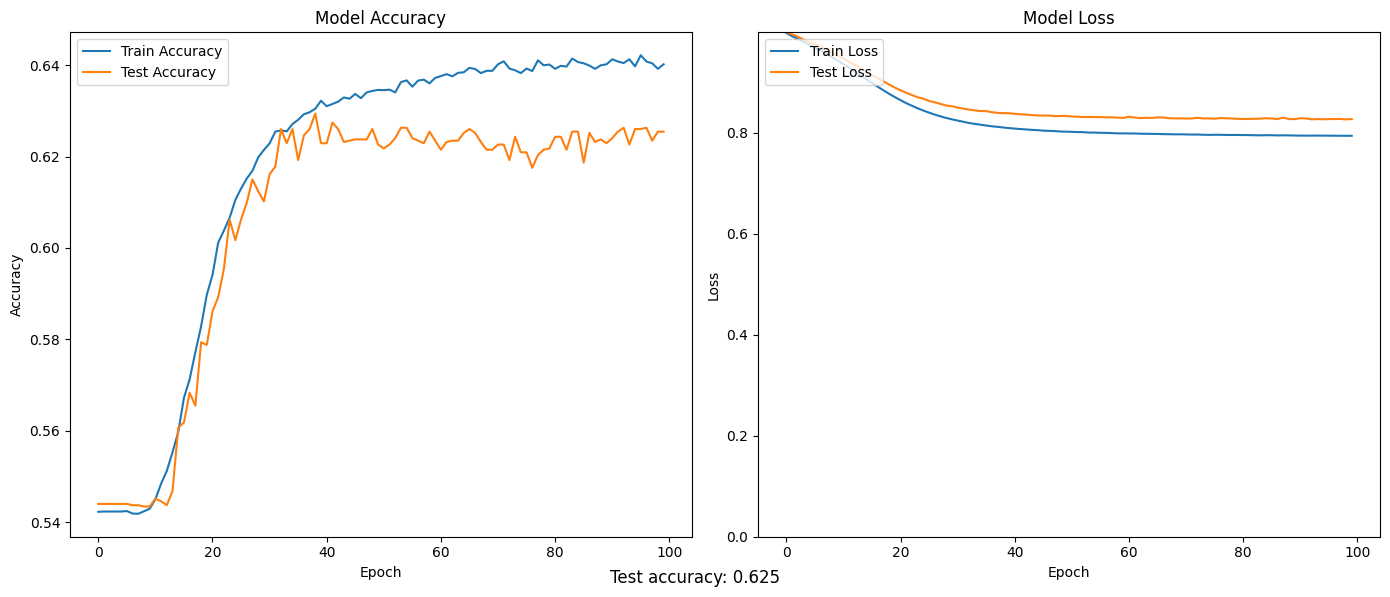

In [128]:
# Set up a figure to host two subplots
plt.figure(figsize=(14, 6))

# Subplot for the accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Subplot for the loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))

# Add test accuracy as a label on the plot
plt.figtext(0.5, 0.02, f"Test accuracy: {test_accuracy:.3f}", fontsize=12, ha='center')  # Adjust the position of text

# Adjust layout to remove white space
plt.tight_layout()
plt.show()


111/111 [==============================] - 0s 846us/step


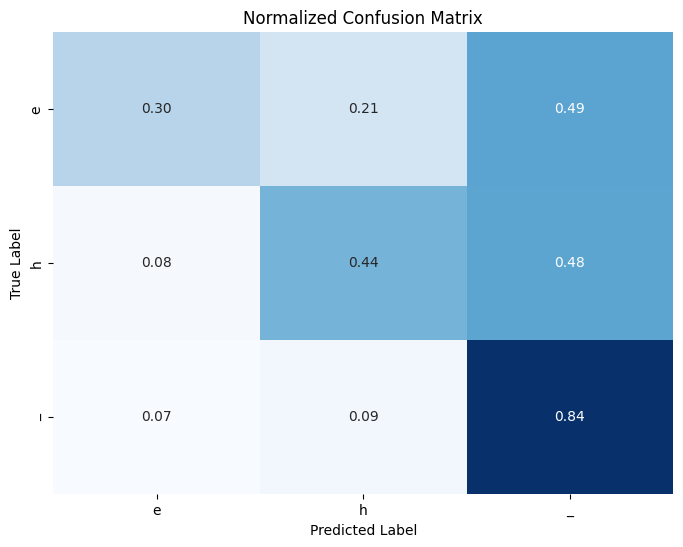

In [129]:
#Confusion matrix normalization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test dataset
y_pred = model.predict(windowed_input_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(elab_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [157]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

def create_sliding_windows(encoded_seqs, window_size=13):
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    windows = np.array([padded_seqs[i:i + window_size] for i in range(len(encoded_seqs))])
    return windows


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_improved_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(input_shape[0], input_shape[1]),
               kernel_regularizer=l2(0.01)),  # Single Conv1D layer with increased filters and L2 regularization
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(40, activation='sigmoid', kernel_regularizer=l2(0.01)),  # L2 regularization on Dense layer
        Dropout(0.3),  # Dropout to prevent overfitting
        Dense(3, activation='softmax')
    ])
    optim = Adam(learning_rate=0.0001)  # Optimizer with a conservative learning rate
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Assuming the presence of functions parse_data, encode_sequences, and encode_labels
# Load and process training data
seq_train, labels_train = parse_data("protein-secondary-structure.train.txt")
eseq_train = encode_sequences(seq_train)
elab_train = encode_labels(labels_train)
windowed_input_train = create_sliding_windows(np.array(eseq_train), window_size=13)

# Load and process testing data
seq_test, labels_test = parse_data("protein-secondary-structure.test.txt")
eseq_test = encode_sequences(seq_test)
elab_test = encode_labels(labels_test)
windowed_input_test = create_sliding_windows(np.array(eseq_test), window_size=13)

# Building the model
model = build_improved_model(windowed_input_train.shape[1:])

# Training the model
history = model.fit(
    windowed_input_train, elab_train,
    epochs=20,
    validation_data=(windowed_input_test, elab_test),
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(windowed_input_test, np.array(elab_test))
print("Test accuracy:", test_accuracy)


Epoch 1/20
569/569 [==============================] - 3s 3ms/step - loss: 1.8677 - accuracy: 0.5160 - val_loss: 1.6515 - val_accuracy: 0.5440
Epoch 2/20
569/569 [==============================] - 2s 3ms/step - loss: 1.5193 - accuracy: 0.5608 - val_loss: 1.3751 - val_accuracy: 0.5827
Epoch 3/20
569/569 [==============================] - 2s 3ms/step - loss: 1.3018 - accuracy: 0.5834 - val_loss: 1.2064 - val_accuracy: 0.6113
Epoch 4/20
569/569 [==============================] - 2s 3ms/step - loss: 1.1660 - accuracy: 0.5932 - val_loss: 1.0994 - val_accuracy: 0.6204
Epoch 5/20
569/569 [==============================] - 2s 3ms/step - loss: 1.0767 - accuracy: 0.6054 - val_loss: 1.0315 - val_accuracy: 0.6130
Epoch 6/20
569/569 [==============================] - 2s 3ms/step - loss: 1.0237 - accuracy: 0.6052 - val_loss: 0.9864 - val_accuracy: 0.6223
Epoch 7/20
569/569 [==============================] - 2s 3ms/step - loss: 0.9808 - accuracy: 0.6104 - val_loss: 0.9552 - val_accuracy: 0.6223
Epoch 

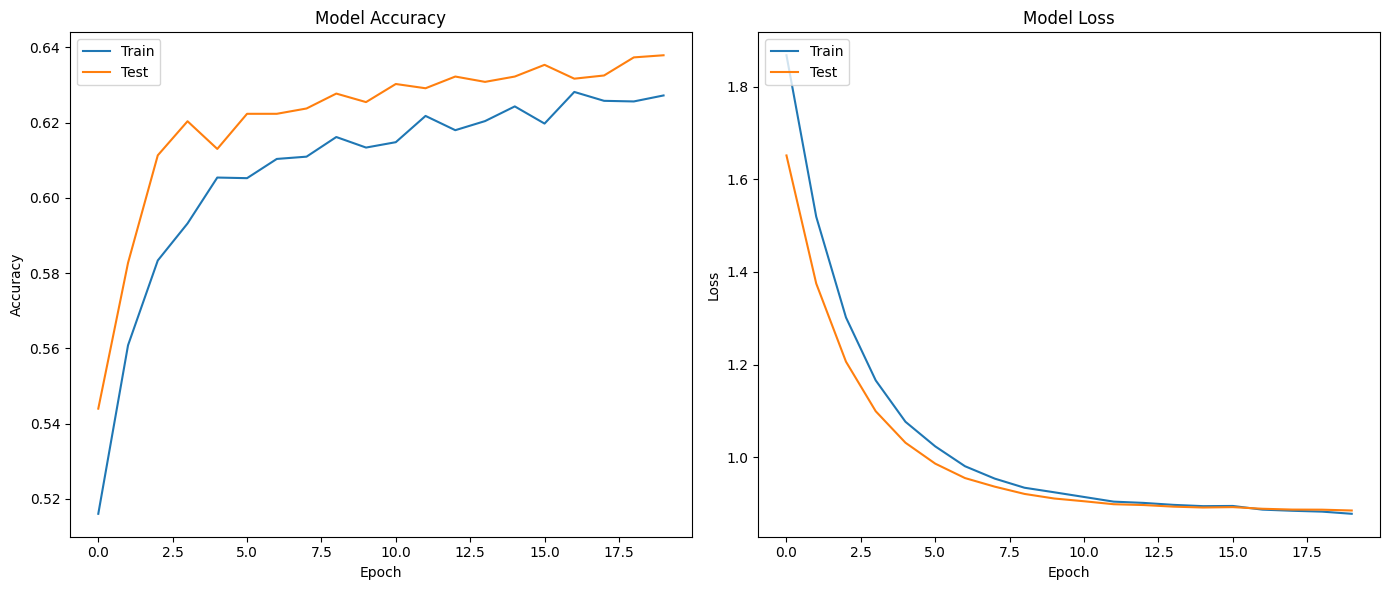

In [158]:

# Plotting the accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

111/111 [==============================] - 0s 1ms/step


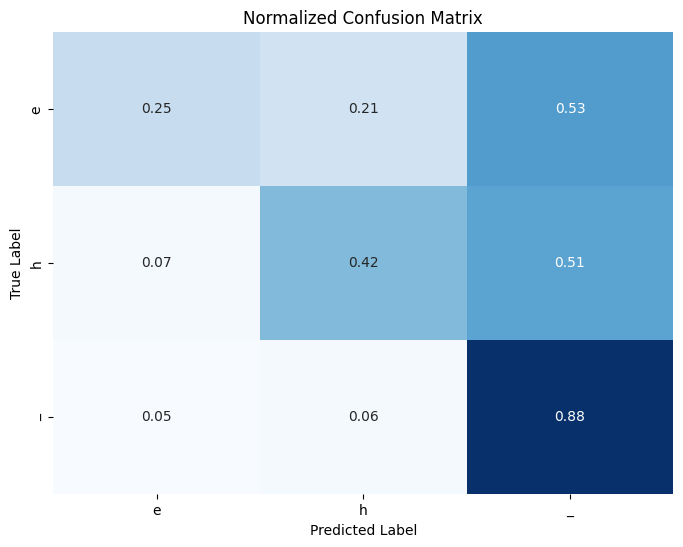

In [159]:
#Confusion matrix normalization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test dataset
y_pred = model.predict(windowed_input_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(elab_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['e', 'h', '_']

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

